За основу взят шаблон из курса Андрея Сазыкина.
https://github.com/sozykin/dlpython_course/blob/master/computer_vision/cats_and_dogs/cats_and_dogs_vgg16-data_augmentation.ipynb

Для улучшения качества взят случай с аугментацией исходных изображений (так как он показал более высокое качество и большую скорость сходимости на отложенной выборке). Так же был произведен дополнительный тюнинг модели что так- же привело к улучшению качества.

In [1]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline 

In [28]:
# Каталог с данными для обучения
train_dir = './/data//01_train//'
# Каталог с данными для проверки
val_dir = './/data//02_val//'
# Каталог с данными для тестирования
test_dir = './/data//03_test//'
# for submite
final_test_dir = './/data//04_test_final//'
# Размеры изображения
img_width, img_height = 224, 224
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 64
# Количество изображений для обучения
nb_train_samples = 17500
# Количество изображений для проверки
nb_validation_samples = 3750
# Количество изображений для тестирования
nb_test_samples = 3750

## Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.

In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

Проверяем работу генератора

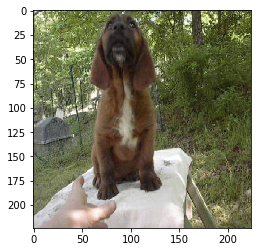

In [4]:
image_file_name = train_dir + '/dogs/dog.5.jpg'
img = image.load_img(image_file_name, target_size=(img_width, img_height))
plt.imshow(img)

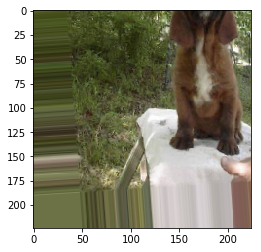

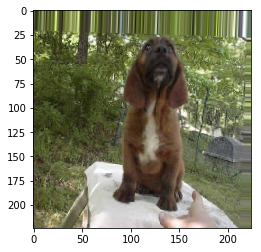

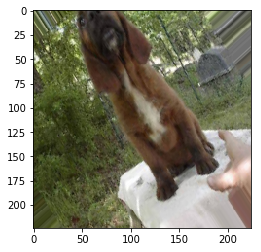

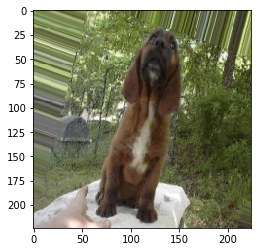

In [5]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Генератор данных для обучения на основе изображений из каталога

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 17500 images belonging to 2 classes.


Создаем генератор для тестирования и проверки, без дополнения данных

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для проверки на основе изображений из каталога

In [8]:
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 3750 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога

In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 3750 images belonging to 2 classes.


In [10]:
#pip install keras

## Загружаем предварительно обученную нейронную сеть

In [11]:
#import keras
#new_model = keras.models.load_model('cats-dogs-vgg16_tune.hdf5')

In [12]:
#mkvirtualenv keras_tf -p python3

In [13]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


"Замораживаем" веса предварительно обученной нейронной сети VGG16

In [14]:
vgg16_net.trainable = False

In [15]:
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Создаем составную нейронную сеть на основе VGG16

In [16]:
model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

Компилируем составную нейронную сеть

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(), 
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Обучаем модель с использованием генераторов

train_generator - генератор данных для обучения

validation_data - генератор данных для проверки

In [19]:
#model.fit_generator(
#    train_generator,
#    steps_per_epoch=100,
#    epochs=10,
#    validation_data=val_generator,
#    validation_steps=25)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/15
273/273 [==============================] - 209s 767ms/step - loss: 0.4685 - acc: 0.8108 - val_loss: 0.2050 - val_acc: 0.9178
Epoch 2/15
273/273 [==============================] - 225s 826ms/step - loss: 0.3188 - acc: 0.8628 - val_loss: 0.1903 - val_acc: 0.9221
Epoch 3/15
273/273 [==============================] - 228s 834ms/step - loss: 0.3157 - acc: 0.8586 - val_loss: 0.2003 - val_acc: 0.9192
Epoch 4/15
273/273 [==============================] - 224s 821ms/step - loss: 0.3010 - acc: 0.8675 - val_loss: 0.1901 - val_acc: 0.9213
Epoch 5/15
273/273 [==============================] - 247s 905ms/step - loss: 0.2925 - acc: 0.8724 - val_loss: 0.1723 - val_acc: 0.9316
Epoch 6/15
273/273 [==============================] - 238s 873ms/step - loss: 0.2829 - acc: 0.8757 - val_loss: 0.1767 - val_acc: 0.9275
Epoch 7/15
273/273 [==============================] - 212s 777ms/step - loss: 0.2804 - acc: 0.8767 - val_loss: 0.1743 - val_acc: 0.9318
Epoch 8/15
273/273 [============================

In [20]:
conda list cudnn

# packages in environment at C:\Users\Volk\Anaconda3:
#
# Name                    Version                   Build  Channel

Note: you may need to restart the kernel to use updated packages.


## Оцениваем качество работы сети с помощью генератора

In [21]:
scores = model.evaluate_generator(test_generator, 50)

In [22]:
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 91.84%


# Тонкая настройка сети (fine tuning)

"Размораживаем" последний сверточный блок сети VGG16

In [23]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block4_conv1':
        trainable = True
    layer.trainable = trainable    

In [24]:
# Проверяем количество обучаемых параметров
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [26]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/5
273/273 [==============================] - 217s 795ms/step - loss: 0.1805 - acc: 0.9235 - val_loss: 0.0900 - val_acc: 0.9685
Epoch 2/5
273/273 [==============================] - 219s 802ms/step - loss: 0.1141 - acc: 0.9545 - val_loss: 0.0808 - val_acc: 0.9720
Epoch 3/5
273/273 [==============================] - 220s 807ms/step - loss: 0.0996 - acc: 0.9625 - val_loss: 0.1017 - val_acc: 0.9663
Epoch 4/5
273/273 [==============================] - 224s 819ms/step - loss: 0.0892 - acc: 0.9659 - val_loss: 0.0879 - val_acc: 0.9749
Epoch 5/5
273/273 [==============================] - 219s 803ms/step - loss: 0.0773 - acc: 0.9699 - val_loss: 0.0703 - val_acc: 0.9768


In [27]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 97.68%


Итоговый log loss (на отложенной выборке): 0.0703

In [63]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(final_test_dir) if isfile(join(final_test_dir, f))]

In [68]:
for f in onlyfiles:
    print(model.predict([load_image(final_test_dir + f)]))

[[1.]]
[[1.1556953e-07]]
[[0.22917089]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.9999987]]
[[0.9939295]]
[[0.]]
[[3.8122823e-07]]
[[0.]]
[[0.]]
[[8.376415e-07]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.00029787]]
[[1.]]
[[0.01199394]]
[[0.]]
[[2.7401182e-08]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.99999964]]
[[1.]]
[[1.]]
[[0.9864811]]
[[1.]]
[[1.]]
[[0.]]
[[0.9997472]]
[[1.]]
[[0.9999987]]
[[6.7044056e-08]]
[[0.01844297]]
[[0.00024488]]
[[1.]]
[[0.99999785]]
[[1.]]
[[0.03440813]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.9580372]]
[[1.]]
[[0.]]
[[0.9999808]]
[[0.99903786]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.05523527]]
[[4.973619e-07]]
[[7.893048e-08]]
[[0.9974921]]
[[8.302952e-08]]
[[0.]]
[[1.]]
[[0.48622283]]
[[0.99999845]]
[[0.998544]]
[[1.]]
[[1.]]
[[1.5600435e-06]]
[[0.]]
[[0.999871]]
[[1.]]
[[0.01897471]]
[[0.00414038]]
[[0.]]
[[0.]]
[[9.785831e-07]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.97771376]]
[[0.]]
[[6.8889414e-05]]
[[4.420688e-08]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[3.6729867e-05]]
[[6.770475e-05]]


[[0.]]
[[0.]]
[[1.]]
[[0.99999774]]
[[4.974866e-08]]
[[0.9999639]]
[[5.6308245e-08]]
[[1.6247556e-06]]
[[1.]]
[[0.]]
[[0.99548054]]
[[1.]]
[[0.99999964]]
[[0.00119326]]
[[0.07437821]]
[[0.9999999]]
[[1.]]
[[0.999998]]
[[0.01461238]]
[[7.05289e-08]]
[[0.19257951]]
[[0.]]
[[0.]]
[[1.]]
[[0.99999976]]
[[8.1237704e-05]]
[[0.9998149]]
[[0.9827779]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[1.1916837e-05]]
[[0.0633035]]
[[0.07611744]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.09807784]]
[[1.]]
[[0.99999976]]
[[0.9440334]]
[[1.]]
[[0.]]
[[0.]]
[[2.4065382e-06]]
[[1.]]
[[2.857997e-08]]
[[5.5139047e-08]]
[[3.7358674e-05]]
[[0.]]
[[0.]]
[[0.9999999]]
[[0.00129148]]
[[0.]]
[[1.]]
[[0.]]
[[0.9984054]]
[[1.]]
[[0.]]
[[1.]]
[[0.95401293]]
[[1.0104186e-07]]
[[2.8476388e-05]]
[[0.00010338]]
[[1.]]
[[1.]]
[[0.00130893]]
[[6.934584e-06]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.00950313]]
[[0.9999614]]
[[0.]]
[[4.2600845e-05]]
[[1.]]
[[0.0007082]]
[[1.]]
[[0.]]
[[0.9984493]]
[[0.]]
[[1.]]
[[3

[[0.36903012]]
[[0.9999957]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.9998548]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[3.7410617e-05]]
[[0.9999939]]
[[0.9439576]]
[[0.99917465]]
[[0.9999819]]
[[0.]]
[[1.5960446e-06]]
[[0.]]
[[0.9999999]]
[[1.]]
[[0.99999976]]
[[5.5099004e-08]]
[[1.]]
[[0.05434971]]
[[0.]]
[[0.99999416]]
[[2.6710368e-06]]
[[0.]]
[[0.]]
[[0.9908669]]
[[1.]]
[[1.]]
[[1.]]
[[0.73418987]]
[[1.]]
[[1.]]
[[0.01130131]]
[[0.]]
[[3.5247245e-05]]
[[1.79745e-05]]
[[1.]]
[[0.00227891]]
[[0.]]
[[0.]]
[[0.]]
[[0.99999034]]
[[0.99999905]]
[[4.998793e-05]]
[[8.277388e-06]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.99998415]]
[[1.]]
[[3.9701613e-06]]
[[0.]]
[[0.]]
[[0.9999987]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[9.0852424e-08]]
[[3.4667828e-05]]
[[0.00296617]]
[[0.96694493]]
[[1.]]
[[0.]]
[[4.5934985e-06]]
[[1.]]
[[0.91988665]]
[[0.]]
[[0.00070169]]
[[1.]]
[[1.]]
[[4.9147316e-06]]
[[0.9999877]]
[[0.9999993]]
[[0.9840566]]
[[1.]]
[[0.9999999]]
[[8.6132405e-07]]
[[0.]]
[[

[[0.8134386]]
[[0.]]
[[1.]]
[[1.]]
[[0.99998164]]
[[0.]]
[[1.]]
[[1.]]
[[0.47582024]]
[[0.]]
[[0.]]
[[0.9999999]]
[[0.]]
[[0.95769966]]
[[1.]]
[[0.99933016]]
[[0.9999993]]
[[2.6059072e-06]]
[[1.]]
[[1.]]
[[0.]]
[[6.4239e-05]]
[[1.]]
[[0.]]
[[1.]]
[[0.00092227]]
[[1.]]
[[0.00097782]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[4.0973664e-05]]
[[0.9977126]]
[[1.]]
[[0.]]
[[1.]]
[[0.9999994]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.99999416]]
[[0.92583996]]
[[1.]]
[[0.99930334]]
[[1.]]
[[1.3747535e-05]]
[[1.]]
[[0.6998769]]
[[1.]]
[[0.3308631]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[1.5516439e-06]]
[[0.9999987]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.17494534]]
[[5.5463943e-06]]
[[1.4539155e-06]]
[[3.55259e-08]]
[[2.594332e-06]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.00186164]]
[[0.00156205]]
[[0.]]
[[1.236212e-06]]
[[0.9999999]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.9999945]]
[[0.8720422]]
[[0.]]
[[3.795746e-05]]
[[1.]]
[[7.6262836e-08]]
[[0.]]
[[0.9961481]]
[[1.]]
[[0.]]
[[0.9999869]]
[[0.99969673]]
[[0.99913

[[0.]]
[[1.]]
[[2.193499e-05]]
[[0.97284657]]
[[0.7264727]]
[[1.0315434e-06]]
[[1.]]
[[0.9999994]]
[[0.]]
[[0.99987173]]
[[2.2713722e-07]]
[[0.]]
[[0.60572976]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.01514616]]
[[0.]]
[[1.541526e-05]]
[[0.999998]]
[[0.]]
[[0.9999989]]
[[0.]]
[[1.]]
[[0.94774973]]
[[4.2408224e-08]]
[[0.]]
[[0.00029366]]
[[1.]]
[[0.]]
[[3.5627666e-06]]
[[0.9975473]]
[[1.]]
[[0.]]
[[0.99999905]]
[[3.3635505e-08]]
[[1.]]
[[1.]]
[[0.9999856]]
[[0.9999999]]
[[5.43951e-08]]
[[0.9999995]]
[[1.]]
[[0.99990773]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[3.5720407e-07]]
[[5.684809e-06]]
[[0.9977531]]
[[0.]]
[[0.07449681]]
[[1.]]
[[1.]]
[[0.6663358]]
[[4.3650758e-07]]
[[0.]]
[[1.]]
[[0.9999974]]
[[4.4955897e-05]]
[[0.5758687]]
[[0.]]
[[1.]]
[[0.00447205]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[5.0402516e-05]]
[[1.]]
[[1.]]
[[0.]]
[[0.99998367]]
[[1.]]
[[0.07204109]]
[[0.01161874]]
[[1.9102096e-07]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.]

[[6.959403e-08]]
[[1.]]
[[0.]]
[[3.550958e-08]]
[[1.]]
[[1.4560145e-05]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.9833229]]
[[2.6708456e-06]]
[[1.]]
[[1.]]
[[0.9999994]]
[[0.]]
[[1.]]
[[0.00016269]]
[[0.81859887]]
[[1.]]
[[0.]]
[[0.00055624]]
[[1.]]
[[0.25892785]]
[[0.9808579]]
[[0.]]
[[1.]]
[[0.]]
[[0.99999034]]
[[1.]]
[[0.37360898]]
[[0.99864346]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[3.5028776e-07]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[2.0431025e-06]]
[[0.]]
[[0.9972675]]
[[0.0470056]]
[[0.9996582]]
[[0.]]
[[1.]]
[[0.]]
[[3.4711487e-08]]
[[0.9987562]]
[[0.]]
[[0.8152826]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[0.99993443]]
[[0.]]
[[8.9381295e-08]]
[[0.]]
[[0.9999958]]
[[0.04928001]]
[[0.99999964]]
[[1.]]
[[1.]]
[[0.99965084]]
[[0.]]
[[0.56407535]]
[[1.]]
[[0.]]
[[0.]]
[[0.9998994]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[1.3008468e-05]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.99999976]]
[[0.]]
[[0.9999119]]
[[0.]]
[[1.]]
[[5.6653366e-06]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[2.

[[0.]]
[[1.]]
[[0.]]
[[1.403762e-05]]
[[0.]]
[[0.99999976]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[0.9999999]]
[[4.7292467e-08]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.99981767]]
[[0.]]
[[1.]]
[[1.]]
[[0.999977]]
[[0.]]
[[0.]]
[[0.]]
[[0.84480095]]
[[0.]]
[[0.9995357]]
[[1.]]
[[1.]]
[[0.0013694]]
[[0.00021743]]
[[0.15356945]]
[[0.]]
[[0.9999989]]
[[3.3895967e-06]]
[[1.]]
[[0.9999976]]
[[0.9991761]]
[[0.9997794]]
[[1.]]
[[0.]]
[[0.9999031]]
[[1.]]
[[1.]]
[[0.]]
[[0.99999976]]
[[0.9972058]]
[[0.9998373]]
[[1.]]
[[1.6171283e-06]]
[[1.]]
[[0.9977197]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[3.783315e-06]]
[[0.99997306]]
[[1.]]
[[8.043927e-06]]
[[1.]]
[[0.96600556]]
[[1.6294838e-07]]
[[0.]]
[[1.]]
[[3.2982292e-08]]
[[0.]]
[[0.]]
[[1.]]
[[1.8049094e-07]]
[[1.]]
[[1.]]
[[0.9999901]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[0.00011868]]
[[0.]]
[[1.]]
[[0.93030846]]
[[1.]]
[[0.00055613]]
[[0.99343175]]
[[3.5179248e-08]]
[[1.7134564e-05]]
[[4.811369e-07]]
[[0.99887496]]
[[5.65

[[2.6441135e-06]]
[[0.9999994]]
[[4.4451067e-08]]
[[0.00521569]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[2.8892414e-06]]
[[0.9999999]]
[[6.473514e-05]]
[[0.]]
[[0.46799728]]
[[0.]]
[[0.9999964]]
[[0.8690812]]
[[0.99999774]]
[[5.557636e-05]]
[[0.]]
[[1.]]
[[1.3354647e-06]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.00314004]]
[[0.00059696]]
[[0.00029467]]
[[1.]]
[[0.99999356]]
[[0.99999666]]
[[0.99999917]]
[[1.]]
[[0.]]
[[1.]]
[[0.96744573]]
[[0.9999887]]
[[0.9998198]]
[[1.]]
[[0.]]
[[0.]]
[[2.7265869e-05]]
[[1.]]
[[0.]]
[[0.0007042]]
[[1.01712285e-05]]
[[1.]]
[[0.]]
[[1.2136041e-05]]
[[0.9987801]]
[[1.254024e-07]]
[[0.9999944]]
[[1.]]
[[0.99999]]
[[0.9568877]]
[[0.22096506]]
[[1.]]
[[0.9995136]]
[[0.02896626]]
[[6.78234e-05]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.00357485]]
[[0.561472]]
[[1.]]
[[1.]]
[[0.99999356]]
[[9.0390895e-06]]
[[1.]]
[[0.99826765]]
[[1.]]
[[0.9999999]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999994]]
[[0.]]
[[0.9985592]]
[[0.00805103]]
[[1.]]
[[0.]]
[[0.97781885]]
[[0.9999997

[[1.]]
[[1.]]
[[8.9548155e-07]]
[[1.]]
[[0.]]
[[0.99999714]]
[[1.]]
[[0.]]
[[1.]]
[[0.9999962]]
[[1.]]
[[1.9068613e-05]]
[[0.9997749]]
[[0.]]
[[0.99971133]]
[[9.879182e-08]]
[[1.]]
[[0.9985245]]
[[0.11019822]]
[[1.]]
[[9.959587e-06]]
[[0.]]
[[5.037605e-07]]
[[0.10049281]]
[[1.]]
[[1.4243518e-07]]
[[0.]]
[[5.907647e-07]]
[[1.]]
[[1.7532528e-05]]
[[0.]]
[[3.8197932e-08]]
[[0.00333547]]
[[0.9999969]]
[[0.99991727]]
[[0.03040675]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[3.9434262e-06]]
[[0.00028646]]
[[0.99999976]]
[[0.00102539]]
[[1.6081714e-07]]
[[0.00608234]]
[[2.5799961e-08]]
[[1.]]
[[0.9999999]]
[[0.9998379]]
[[1.]]
[[1.]]
[[0.99998343]]
[[0.]]
[[2.6483306e-07]]
[[0.5981577]]
[[1.]]
[[1.]]
[[1.5692038e-06]]
[[0.]]
[[2.6980879e-05]]
[[0.]]
[[0.9853212]]
[[1.29538985e-05]]
[[0.]]
[[0.999778]]
[[0.]]
[[0.06627392]]
[[0.999622]]
[[7.316855e-07]]
[[0.]]
[[0.32857013]]
[[0.]]
[[0.]]
[[8.753964e-06]]
[[0.]]
[[0.03510996]]
[[0.9999894]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[3.4726665e-06]]
[[1.]]
[[0.99

[[0.]]
[[0.99999905]]
[[0.99998546]]
[[0.36121452]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[0.61407274]]
[[1.1479797e-05]]
[[0.00128246]]
[[0.99999666]]
[[0.]]
[[0.9979234]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9997038]]
[[0.]]
[[0.9999999]]
[[1.]]
[[3.7128346e-05]]
[[0.]]
[[8.120409e-05]]
[[0.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999945]]
[[1.]]
[[0.99999654]]
[[3.7679576e-05]]
[[0.]]
[[1.]]
[[0.9999993]]
[[0.9984763]]
[[1.]]
[[0.9951892]]
[[0.]]
[[0.005175]]
[[0.]]
[[1.]]
[[0.16689935]]
[[1.]]
[[1.]]
[[0.99999976]]
[[1.2946185e-07]]
[[0.98627186]]
[[1.]]
[[1.]]
[[0.3039509]]
[[1.1045165e-06]]
[[0.9995357]]
[[0.9999999]]
[[2.4620856e-06]]
[[0.]]
[[0.]]
[[2.9222932e-07]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[3.0145907e-07]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[1.1458515e-06]]
[[0.]]
[[1.]]
[[0.9537712]]
[[0.]]
[[0.]]
[[1.]]
[[0.00040224]]
[[0.]]
[[0.9994634]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.4151622]]
[[1.]]
[[0.07999636]]
[[0.]]
[[0.9999999]]
[[0.]

[[0.]]
[[1.]]
[[0.]]
[[5.5785247e-05]]
[[0.00017234]]
[[1.286683e-07]]
[[0.]]
[[1.]]
[[0.]]
[[2.6595959e-07]]
[[1.]]
[[0.]]
[[1.]]
[[9.703802e-08]]
[[0.9768141]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.0061065]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[0.0151214]]
[[1.]]
[[0.]]
[[4.8087557e-05]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9925053]]
[[1.]]
[[5.9035862e-08]]
[[1.]]
[[0.08722945]]
[[9.394045e-05]]
[[0.8071951]]
[[0.00084728]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.6469204e-06]]
[[1.4427675e-06]]
[[0.8550273]]
[[1.]]
[[0.]]
[[0.9999995]]
[[0.9999995]]
[[0.]]
[[1.]]
[[0.]]
[[1.8231067e-06]]
[[1.]]
[[1.]]
[[1.527848e-08]]
[[0.]]
[[0.99999917]]
[[0.17621855]]
[[0.9999987]]
[[0.00734142]]
[[1.]]
[[0.00010881]]
[[0.00010504]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[9.156686e-06]]
[[0.]]
[[3.5167861e-06]]
[[0.9996209]]
[[0.9995484]]
[[0.99999523]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.]]
[[7.485438e-06]]
[[4.9075467e-08]]
[[1.]]
[[1.]]
[[0.40

[[0.99999833]]
[[0.]]
[[1.1648317e-07]]
[[0.]]
[[0.9999999]]
[[0.99999964]]
[[0.]]
[[2.0001034e-08]]
[[0.00015858]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[0.99999964]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[0.9999993]]
[[0.]]
[[0.]]
[[1.]]
[[0.00397524]]
[[7.3955114e-08]]
[[1.]]
[[1.]]
[[0.]]
[[0.9999927]]
[[0.9998311]]
[[1.6193337e-06]]
[[1.]]
[[1.]]
[[1.8555461e-08]]
[[0.9999981]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.7975455]]
[[6.6286175e-06]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[0.00198454]]
[[0.9999975]]
[[0.]]
[[0.]]
[[1.5889015e-08]]
[[1.]]
[[1.]]
[[1.]]
[[0.4302733]]
[[1.]]
[[1.]]
[[1.]]
[[0.00011666]]
[[0.]]
[[0.03856947]]
[[0.99991465]]
[[0.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[1.]]
[[0.99999475]]
[[0.99969685]]
[[0.]]
[[0.]]
[[0.99862456]]
[[0.]]
[[1.]]
[[1.]]
[[0.9999628]]
[[0.]]
[[0.9999548]]
[[0.99999154]]
[[0.992886]]
[[0.]]
[[1.8707237e-08]]
[[1.]]
[[0.9999552]]
[[1.]]
[[3.475628e-05]]
[[0.]]
[[0.]]
[[1.]]
[[0.99854445]]
[[0.00090791]]
[[0.9999969]]
[[0.]]

[[0.9993773]]
[[3.2362817e-07]]
[[1.]]
[[0.]]
[[0.9999999]]
[[4.270491e-07]]
[[1.6648645e-06]]
[[5.0222113e-08]]
[[0.08204001]]
[[0.]]
[[0.5926079]]
[[1.]]
[[0.00116612]]
[[1.]]
[[1.]]
[[0.00026982]]
[[0.]]
[[0.02149769]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[2.6875814e-06]]
[[0.]]
[[1.]]
[[0.09792235]]
[[0.00014901]]
[[0.00366798]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[2.2837382e-06]]
[[0.]]
[[0.9999988]]
[[1.]]
[[0.9999999]]
[[4.9561515e-07]]
[[4.1008704e-08]]
[[0.9998031]]
[[1.]]
[[0.]]
[[0.99999654]]
[[0.]]
[[0.9999461]]
[[0.]]
[[0.]]
[[0.99999976]]
[[0.9999999]]
[[0.9999956]]
[[0.]]
[[0.]]
[[0.]]
[[1.8752377e-06]]
[[0.9997209]]
[[4.519981e-06]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[1.2349288e-06]]
[[0.00022945]]
[[0.9958592]]
[[0.]]
[[1.]]
[[0.9999999]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.00046874]]
[[1.]]
[[1.]]
[[8.1282074e-08]]
[[1.]]
[[1.]]
[[0.]]
[[0.]]
[[2.0387313e-08]]
[[0.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[5.272999e-08]]
[[1.]]
[[0.]]
[[2.4629904e-05]]
[[1.]]
[[0.9997

[[0.01841032]]
[[0.9629585]]
[[1.]]
[[0.]]
[[0.9996257]]
[[0.9984598]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.9999883]]
[[0.]]
[[3.242381e-05]]
[[0.]]
[[4.537268e-05]]
[[1.]]
[[0.8296229]]
[[0.]]
[[7.0761257e-07]]
[[0.9999999]]
[[2.1791813e-05]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[5.828623e-06]]
[[1.]]
[[1.]]
[[0.10830094]]
[[0.0157003]]
[[1.]]
[[0.]]
[[0.9988416]]
[[0.]]
[[0.9999999]]
[[0.9999999]]
[[2.2406892e-05]]
[[0.0003006]]
[[0.9999907]]
[[0.]]
[[0.99997544]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[0.0003149]]
[[0.]]
[[0.9999882]]
[[0.99999976]]
[[1.]]
[[0.]]
[[0.]]
[[0.]]
[[0.99999285]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[1.7360791e-05]]
[[1.]]
[[0.2523128]]
[[1.]]
[[0.]]
[[1.7117856e-05]]
[[0.00785731]]
[[1.]]
[[0.99935097]]
[[0.9562105]]
[[1.]]
[[0.]]
[[0.]]
[[1.]]
[[0.8991334]]
[[1.]]
[[0.98894495]]
[[1.]]
[[0.]]
[[1.]]
[[0.9932666]]
[[1.]]
[[0.]]
[[9.3789895e-06]]
[[0.99949384]]
[[0.99999917]]
[[6.764682e-06]]
[[1.]]
[[0.9631134]]
[[0.00088081]]
[

[[3.1481793e-06]]
[[0.]]
[[1.]]
[[1.]]
[[0.9999989]]
[[0.00027056]]
[[0.9999999]]
[[0.]]
[[0.]]
[[1.]]
[[0.9999994]]
[[0.]]
[[1.]]
[[0.17819239]]
[[0.]]
[[0.]]
[[1.]]
[[3.2475913e-07]]
[[0.702831]]
[[0.9999999]]
[[1.]]
[[0.]]
[[1.6029959e-07]]
[[0.99988854]]
[[0.]]
[[1.]]
[[0.9999783]]
[[0.9999999]]
[[0.9920042]]
[[0.74777836]]
[[0.4213191]]
[[1.]]
[[0.99999833]]
[[0.]]
[[0.2412684]]
[[1.]]
[[0.00069302]]
[[0.39050528]]
[[0.9924752]]
[[1.]]
[[1.]]
[[0.]]
[[2.1690032e-06]]
[[2.2461833e-08]]
[[0.]]
[[0.99999976]]
[[1.]]
[[4.011585e-06]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.]]
[[0.00128948]]
[[0.]]
[[0.]]
[[0.94386154]]
[[0.9999989]]
[[0.]]
[[1.]]
[[0.99999845]]
[[1.]]
[[0.]]
[[0.99996805]]
[[0.9999995]]
[[0.32720393]]
[[0.]]
[[0.]]
[[0.]]
[[0.99988806]]
[[0.9999995]]
[[0.09962201]]
[[0.]]
[[0.]]
[[1.]]
[[0.92468506]]
[[0.]]
[[0.]]
[[1.]]
[[0.]]
[[0.]]
[[0.01830525]]
[[0.9998429]]
[[0.99597174]]
[[0.]]
[[0.]]
[[0.]]
[[6.28456e-06]]
[[1.]]
[[0.]]
[[0.99999905]]
[[0.]]
[[0.99999857]]
[[1.]]
[[1.

[[1.]]
[[2.9484636e-06]]
[[1.]]
[[0.]]
[[0.9999728]]
[[1.]]
[[0.00152137]]
[[0.]]
[[1.]]
[[8.410472e-05]]
[[0.99999976]]
[[1.]]
[[0.99998915]]
[[0.00297563]]
[[0.20726447]]
[[1.]]
[[1.]]
[[0.1704425]]
[[0.9999999]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.01329312]]
[[1.0955818e-05]]
[[0.9934695]]
[[2.0909857e-07]]
[[1.]]
[[0.00612295]]
[[1.]]
[[1.7194684e-07]]
[[0.9949058]]
[[0.]]
[[0.]]
[[0.99998736]]
[[1.]]
[[0.9996118]]
[[0.]]
[[2.0377676e-05]]
[[0.]]
[[1.]]
[[6.0224187e-07]]
[[0.]]
[[1.]]
[[0.]]
[[1.]]
[[0.02646908]]
[[1.]]
[[0.89216167]]
[[1.2101392e-06]]
[[2.380596e-06]]
[[0.]]
[[0.]]
[[0.9999968]]
[[1.8984336e-08]]
[[0.00010085]]
[[0.]]
[[2.1049205e-08]]
[[0.]]
[[1.]]
[[0.]]
[[0.9999999]]
[[0.9999993]]
[[0.02267947]]
[[8.5581384e-08]]
[[0.9930161]]
[[0.9795289]]
[[1.]]
[[1.]]
[[0.]]
[[1.]]
[[1.]]
[[0.]]
[[1.7475057e-07]]
[[0.]]
[[8.109702e-08]]
[[0.]]
[[0.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999404]]
[[0.]]
[[0.]]
[[1.]]
[[1.3510223e-05]]
[[1.]]
[[0.00096654]]
[[1.]]
[[6.22215e-05]]
[[0.]]
[[1

In [72]:
import re
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path in onlyfiles:
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), int(model.predict([load_image(final_test_dir + path)]))))

In [ ]:
Показатель score  в соревновании на kaggle: 6.98236